Simple vector multiplication 

In [4]:
import numpy as np

weights = np.array([-3.0, -1.0, 2.0])
bias = 1.0
inputs = np.array([1.0, -2.0, 3.0])
target_output = 0.0
learning_rate = 0.001

z = np.dot(weights, inputs) + bias
z


6.0

Backpropagation 

In [5]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x>0, 1.0, 0.0)

for i in range(100):

    #forward pass 
    z = np.dot(weights, inputs) + bias
    a = relu(z)
    loss = (a - target_output) ** 2

    #backward pass 
    dloss_relu = 2 * (a - target_output) # derivative of loss activation
    dloss_sum = relu_derivative(z) # derivative of sum
    # dloss_sum is 1 where z > 0, otherwise 0

    dloss_weight = inputs # because weights * inputs so der(inputs) = weights, der(weights) = inputs  
    dloss_bias = 1.0 


    # multiply the derivatives together
    dloss_linear = dloss_relu * dloss_sum
    
    dloss_weights = dloss_linear * dloss_weight
    dloss_bias = dloss_linear * dloss_bias

    # gradient descent step
    weights -= learning_rate * dloss_weights
    bias -= learning_rate * dloss_bias

    print(f"Iteration {i + 1}, Loss: {loss}")

print("Final weights:", weights)
print("Final bias:", bias)



Iteration 1, Loss: 36.0
Iteration 2, Loss: 33.872399999999985
Iteration 3, Loss: 31.870541159999995
Iteration 4, Loss: 29.98699217744401
Iteration 5, Loss: 28.21476093975706
Iteration 6, Loss: 26.54726856821742
Iteration 7, Loss: 24.978324995835766
Iteration 8, Loss: 23.502105988581878
Iteration 9, Loss: 22.113131524656684
Iteration 10, Loss: 20.80624545154949
Iteration 11, Loss: 19.576596345362915
Iteration 12, Loss: 18.419619501351963
Iteration 13, Loss: 17.331019988822064
Iteration 14, Loss: 16.306756707482677
Iteration 15, Loss: 15.343027386070442
Iteration 16, Loss: 14.43625446755368
Iteration 17, Loss: 13.583071828521266
Iteration 18, Loss: 12.780312283455652
Iteration 19, Loss: 12.024995827503426
Iteration 20, Loss: 11.314318574097976
Iteration 21, Loss: 10.645642346368787
Iteration 22, Loss: 10.016484883698395
Iteration 23, Loss: 9.424510627071816
Iteration 24, Loss: 8.867522049011871
Iteration 25, Loss: 8.34345149591527
Iteration 26, Loss: 7.850353512506679
Iteration 27, Loss:

Dense Layer 

In [6]:
class DenseLayer:

    def __init__(self, input_size, n_neurons, weight_regularizer_l1=0, bias_regularizer_l1=0, weight_regularizer_l2=0, bias_regularizer_l2=0):
        
        self.weight_regularizer_l1 = weight_regularizer_l1
        self.bias_regularizer_l1 = bias_regularizer_l1  
        self.weight_regularizer_l2 = weight_regularizer_l2
        self.bias_regularizer_l2 = bias_regularizer_l2
        self.weights = np.random.randn(input_size, n_neurons) * 0.01
        self.bias = np.zeros((1, n_neurons))

    def forward(self, inputs):
        
        self.inputs = inputs
        self.output = np.dot(inputs, self.weights) + self.bias
    
    def backward(self, dvalues):

        self.dweights = np.dot(self.inputs.T , dvalues)
        self.dinputs = np.dot(dvalues, self.weights.T)
        self.dbias = np.sum(dvalues, axis=0, keepdims=True)

        # Apply regularization

        if self.weight_regularizer_l1 > 0:
            # if 1 then add 1, if -1 then add -1 to the dweights
            dl1 = np.ones_like(self.weights)
            dl1[self.weights < 0] = -1  
            self.dweights += self.weight_regularizer_l1 * dl1

        if self.weight_regularizer_l2 > 0:
            self.dweights += 2 * self.weight_regularizer_l2 * self.weights
        
        if self.bias_regularizer_l1 > 0:
            dl1 = np.ones_like(self.bias)
            dl1[self.bias < 0] = -1  
            self.dbias += self.bias_regularizer_l1 * dl1

        if self.bias_regularizer_l2 > 0:
            self.dbias += 2 * self.bias_regularizer_l2 * self.bias

            

Activation RELU

In [7]:
class ActivationReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = np.maximum(0, inputs)

    def backward(self, dvalues):
        self.dinputs = dvalues.copy()
        # set gradient to 0 where inputs are less than or equal to 0 
        # why we dont do for when self.inputs > 0 because it is 1 and when multiplied with dvalues it will not change the value
        self.dinputs[self.inputs <= 0] = 0 

Actiation Softmax

In [8]:
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilitites = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        self.output = probabilitites

Loss 

In [9]:
class Loss:
    
    def regularization_loss(self, layer):
        
        regularization_loss = 0

        if layer.weight_regularizer_l1 > 0:
            regularization_loss += layer.weight_regularizer_l1 * np.sum(np.abs(layer.weights))
        if layer.bias_regularizer_l1 > 0:
            regularization_loss += layer.bias_regularizer_l1 * np.sum(np.abs(layer.bias))
        if layer.weight_regularizer_l2 > 0:
            regularization_loss += layer.weight_regularizer_l2 * np.sum(layer.weights ** 2)
        if layer.bias_regularizer_l2 > 0:
            regularization_loss += layer.bias_regularizer_l2 * np.sum(layer.bias ** 2)
            
        return regularization_loss
    

    def calculate(self, y_pred, y_true):
        sample_losses = self.forward(y_pred, y_true)
        data_loss = np.mean(sample_losses)
        return data_loss
    
class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)

        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)
        negative_log_likelihoods = -np.log(correct_confidences)

        return negative_log_likelihoods
    def backward(self, d_values, y_true):
        
        samples = len(d_values)
        labels = len(d_values[0])

        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        self.dinputs = -y_true / d_values
        self.dinputs = self.dinputs / samples

        


In [10]:
class Activation_Softmax_Loss_CategoricalCrossentropy:
    def __init__(self):
        
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()

    def forward(self, inputs, y_true):

        self.activation.forward(inputs)
        self.output = self.activation.output
        return self.loss.calculate(self.activation.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()
        self.dinputs[range(samples), y_true] -= 1
        self.dinputs = self.dinputs / samples

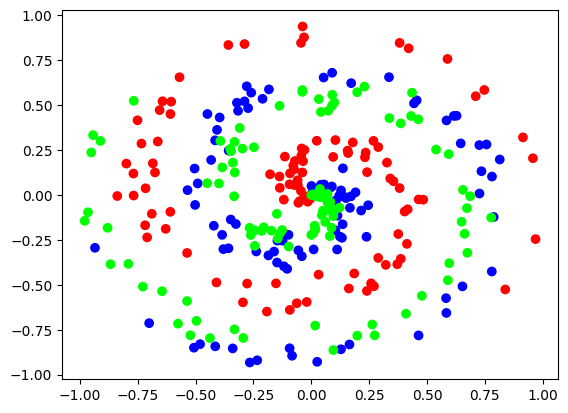

In [11]:
from nnfs.datasets import spiral_data
import numpy as np
import nnfs
nnfs.init()
import matplotlib.pyplot as plt
X, y = spiral_data(samples=100, classes=3)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='brg')
plt.show()

In [12]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 3)
activation1 = ActivationReLU()
dense2 = DenseLayer(3, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()

dense1.forward(X)
activation1.forward(dense1.output)  
dense2.forward(activation1.output)
loss = activation2.forward(dense2.output, y)

print('first 5 loss: ', activation2.output[:5], '\n')
print('loss', loss)

predictions = np.argmax(activation2.output, axis=1)
if len(y.shape) == 2:
 y = np.argmax(y, axis=1)
accuracy = np.mean(predictions == y)
print('accuracy:  ', accuracy, '\n')

activation2.backward(activation2.output, y)
dense2.backward(activation2.dinputs)
activation1.backward(dense2.dinputs)
dense1.backward(activation1.dinputs)


print('dweights1: ', dense1.dweights, '\n')
print('dbias1: ', dense1.dbias, '\n')
print('dweights2: ', dense2.dweights, '\n') 
print('dbias2: ', dense2.dbias, '\n')


first 5 loss:  [[0.33333334 0.33333334 0.33333334]
 [0.33333334 0.33333334 0.33333334]
 [0.33333334 0.3333333  0.33333334]
 [0.3333335  0.333333   0.33333352]
 [0.33333334 0.33333334 0.33333334]] 

loss 1.0986118
accuracy:   0.33666666666666667 

dweights1:  [[ 7.7209341e-05 -1.0590541e-04 -8.3512561e-05]
 [ 2.8525142e-04  6.1521474e-05 -9.9994701e-05]] 

dbias1:  [[ 0.00036935 -0.00025332  0.00021116]] 

dweights2:  [[ 1.0425548e-04  1.5916037e-05 -1.2017150e-04]
 [-4.9149978e-05  1.9419583e-04 -1.4504585e-04]
 [ 3.6147623e-05  1.0825427e-04 -1.4440189e-04]] 

dbias2:  [[ 1.0384247e-05 -1.0518939e-05  3.9814040e-08]] 



Vanilla Gradient Descent

In [13]:
class Optimizer_VGD:
    def __init__(self, learning_rate=0.5):
        self.learning_rate = learning_rate
    def update_params(self, layer):
        layer.weights += -self.learning_rate * layer.dweights
        layer.bias += -self.learning_rate * layer.dbias

Gradient Descent with Decay

with Gradient Descent 

In [14]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 3)
activation1 = ActivationReLU()
dense2 = DenseLayer(3, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_VGD()

for i in range(10000):
    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)
    loss = activation2.forward(dense2.output, y)


    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss}, accuracy: {accuracy}')


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.update_params(dense1)
    optimizer.update_params(dense2)


iteration 1, loss: 1.0986114740371704, accuracy: 0.36333333333333334
iteration 101, loss: 1.0985682010650635, accuracy: 0.38666666666666666


iteration 201, loss: 1.0975860357284546, accuracy: 0.39666666666666667
iteration 301, loss: 1.0861854553222656, accuracy: 0.42333333333333334
iteration 401, loss: 1.0777028799057007, accuracy: 0.43333333333333335
iteration 501, loss: 1.0763813257217407, accuracy: 0.4166666666666667
iteration 601, loss: 1.0758723020553589, accuracy: 0.4066666666666667
iteration 701, loss: 1.0756585597991943, accuracy: 0.4
iteration 801, loss: 1.0755653381347656, accuracy: 0.38
iteration 901, loss: 1.0755252838134766, accuracy: 0.37
iteration 1001, loss: 1.0755072832107544, accuracy: 0.39
iteration 1101, loss: 1.0754972696304321, accuracy: 0.39666666666666667
iteration 1201, loss: 1.0754932165145874, accuracy: 0.4
iteration 1301, loss: 1.0754907131195068, accuracy: 0.4
iteration 1401, loss: 1.0754886865615845, accuracy: 0.4
iteration 1501, loss: 1.0754870176315308, accuracy: 0.4066666666666667
iteration 1601, loss: 1.0754855871200562, accuracy: 0.4066666666666667
iteration 1701, loss: 1.0754852294921875,

Optimizer with decay learning rate

In [15]:
class Optimizer_SGD:
    def __init__(self, learning_rate=1., decay = 0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1 + self.decay * self.iterations))
        

    def post_update_params(self):
        self.iterations += 1
    def update_params(self, layer):
        layer.weights -= self.current_learning_rate * layer.dweights
        layer.bias -= self.current_learning_rate * layer.dbias

In [16]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 64)
activation1 = ActivationReLU()
dense2 = DenseLayer(64, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD(decay=1e-3)

for i in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)
    loss = activation2.forward(dense2.output, y)


    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss}, accuracy: {accuracy}, lr: {optimizer.current_learning_rate}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

iteration 1, loss: 1.098641037940979, accuracy: 0.29, lr: 1.0
iteration 101, loss: 1.0794661045074463, accuracy: 0.4266666666666667, lr: 0.9099181073703367
iteration 201, loss: 1.064527153968811, accuracy: 0.44333333333333336, lr: 0.8340283569641367
iteration 301, loss: 1.0634781122207642, accuracy: 0.44666666666666666, lr: 0.7698229407236336
iteration 401, loss: 1.0631181001663208, accuracy: 0.44666666666666666, lr: 0.7147962830593281
iteration 501, loss: 1.0625474452972412, accuracy: 0.45, lr: 0.66711140760507
iteration 601, loss: 1.0617464780807495, accuracy: 0.44666666666666666, lr: 0.6253908692933083
iteration 701, loss: 1.0604082345962524, accuracy: 0.44, lr: 0.5885815185403178
iteration 801, loss: 1.058395504951477, accuracy: 0.44, lr: 0.5558643690939411
iteration 901, loss: 1.0555909872055054, accuracy: 0.44, lr: 0.526592943654555
iteration 1001, loss: 1.051777958869934, accuracy: 0.44333333333333336, lr: 0.5002501250625312
iteration 1101, loss: 1.0469311475753784, accuracy: 0.

Optimizer Momentum 

In [17]:
class Optimizer_SGD_with_Momentum:
    def __init__(self, learning_rate=1., decay=0., momentum=0.):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
       
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1 + self.decay * self.iterations))

    def post_update_params(self):
        self.iterations += 1

    def update_params(self, layer):

        if self.momentum:
            if not hasattr(layer, 'weight_momentums'):

                layer.weight_momentums = np.zeros_like(layer.weights)
                layer.bias_momentums = np.zeros_like(layer.bias)

            weight_updates = self.momentum * layer.weight_momentums - self.current_learning_rate * layer.dweights
            bias_updates = self.momentum * layer.bias_momentums - self.current_learning_rate * layer.dbias

            layer.weight_momentums = weight_updates
            layer.bias_momentums = bias_updates
        
        else:

            weight_updates = -self.current_learning_rate * layer.dweights
            bias_updates = -self.current_learning_rate * layer.dbias

        layer.weights += weight_updates
        layer.bias += bias_updates


In [18]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 64)
activation1 = ActivationReLU()
dense2 = DenseLayer(64, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_SGD_with_Momentum(decay=1e-3, momentum=0.9)

for i in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)
    loss = activation2.forward(dense2.output, y)


    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, lr: {optimizer.current_learning_rate:.4f}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

iteration 1, loss: 1.0986, accuracy: 0.3100, lr: 1.0000
iteration 101, loss: 1.0159, accuracy: 0.4900, lr: 0.9099
iteration 201, loss: 0.9290, accuracy: 0.4633, lr: 0.8340
iteration 301, loss: 0.8662, accuracy: 0.5967, lr: 0.7698
iteration 401, loss: 0.6486, accuracy: 0.6800, lr: 0.7148
iteration 501, loss: 0.6327, accuracy: 0.7100, lr: 0.6671
iteration 601, loss: 0.5116, accuracy: 0.7733, lr: 0.6254
iteration 701, loss: 0.4470, accuracy: 0.8067, lr: 0.5886
iteration 801, loss: 0.3837, accuracy: 0.8433, lr: 0.5559
iteration 901, loss: 0.3398, accuracy: 0.8433, lr: 0.5266
iteration 1001, loss: 0.3144, accuracy: 0.8533, lr: 0.5003
iteration 1101, loss: 0.2941, accuracy: 0.8733, lr: 0.4764
iteration 1201, loss: 0.2799, accuracy: 0.8867, lr: 0.4548
iteration 1301, loss: 0.2697, accuracy: 0.8867, lr: 0.4350
iteration 1401, loss: 0.2623, accuracy: 0.8867, lr: 0.4168
iteration 1501, loss: 0.2564, accuracy: 0.8933, lr: 0.4002
iteration 1601, loss: 0.2517, accuracy: 0.8900, lr: 0.3848
iteration

Adagrad Optimizer

In [19]:
class Optimizer_AdaGrad:
    def __init__(self, learning_rate=1., decay=0., momentum=0., epsilon=1e-7):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
        self.epsilon = epsilon
       
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1 + self.decay * self.iterations))

    def post_update_params(self):
        self.iterations += 1

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.bias)       
        
        layer.weight_cache += layer.dweights ** 2
        layer.bias_cache += layer.dbias ** 2

        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.bias += -self.current_learning_rate * layer.dbias / (np.sqrt(layer.bias_cache) + self.epsilon)



In [20]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 64)
activation1 = ActivationReLU()
dense2 = DenseLayer(64, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_AdaGrad(decay=1e-3)

for i in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)
    loss = activation2.forward(dense2.output, y)


    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, lr: {optimizer.current_learning_rate:.4f}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

iteration 1, loss: 1.0986, accuracy: 0.2533, lr: 1.0000
iteration 101, loss: 0.9616, accuracy: 0.4533, lr: 0.9099
iteration 201, loss: 0.9032, accuracy: 0.5433, lr: 0.8340
iteration 301, loss: 0.8521, accuracy: 0.6233, lr: 0.7698
iteration 401, loss: 0.8045, accuracy: 0.6333, lr: 0.7148
iteration 501, loss: 0.7625, accuracy: 0.7100, lr: 0.6671
iteration 601, loss: 0.7277, accuracy: 0.6800, lr: 0.6254
iteration 701, loss: 0.6852, accuracy: 0.7067, lr: 0.5886
iteration 801, loss: 0.6512, accuracy: 0.7200, lr: 0.5559
iteration 901, loss: 0.6260, accuracy: 0.7233, lr: 0.5266
iteration 1001, loss: 0.6047, accuracy: 0.7400, lr: 0.5003
iteration 1101, loss: 0.5870, accuracy: 0.7600, lr: 0.4764
iteration 1201, loss: 0.5732, accuracy: 0.7667, lr: 0.4548
iteration 1301, loss: 0.5602, accuracy: 0.7667, lr: 0.4350
iteration 1401, loss: 0.5487, accuracy: 0.7733, lr: 0.4168
iteration 1501, loss: 0.5394, accuracy: 0.7767, lr: 0.4002
iteration 1601, loss: 0.5304, accuracy: 0.7767, lr: 0.3848
iteration

RMS Optimizer

In [21]:
class Optimizer_RMSProp:
    def __init__(self, learning_rate=1., decay=0., momentum=0., epsilon=1e-7, rho=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.momentum = momentum
        self.iterations = 0
        self.epsilon = epsilon
        self.rho = rho
       
    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1 + self.decay * self.iterations))

    def post_update_params(self):
        self.iterations += 1

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.bias)       
        
        layer.weight_cache =  self.rho * layer.weight_cache + (1 - self.rho)* layer.dweights ** 2
        layer.bias_cache =  self.rho * layer.bias_cache + (1 - self.rho)* layer.dbias ** 2
        
        layer.weights += -self.current_learning_rate * layer.dweights / (np.sqrt(layer.weight_cache) + self.epsilon)
        layer.bias += -self.current_learning_rate * layer.dbias / (np.sqrt(layer.bias_cache) + self.epsilon)



In [22]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 64)
activation1 = ActivationReLU()
dense2 = DenseLayer(64, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_RMSProp(learning_rate=0.02, decay=1e-3, rho=0.999)

for i in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)
    loss = activation2.forward(dense2.output, y)


    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)

    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, lr: {optimizer.current_learning_rate:.4f}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

iteration 1, loss: 1.0986, accuracy: 0.2767, lr: 0.0200
iteration 101, loss: 1.0416, accuracy: 0.4667, lr: 0.0182
iteration 201, loss: 1.0293, accuracy: 0.4267, lr: 0.0167
iteration 301, loss: 1.0164, accuracy: 0.4333, lr: 0.0154
iteration 401, loss: 1.0054, accuracy: 0.4533, lr: 0.0143
iteration 501, loss: 0.9921, accuracy: 0.5000, lr: 0.0133
iteration 601, loss: 0.9855, accuracy: 0.4933, lr: 0.0125
iteration 701, loss: 0.9581, accuracy: 0.5233, lr: 0.0118
iteration 801, loss: 0.9295, accuracy: 0.5000, lr: 0.0111
iteration 901, loss: 0.9148, accuracy: 0.5033, lr: 0.0105
iteration 1001, loss: 0.8991, accuracy: 0.5333, lr: 0.0100
iteration 1101, loss: 0.8903, accuracy: 0.5367, lr: 0.0095
iteration 1201, loss: 0.8805, accuracy: 0.5167, lr: 0.0091
iteration 1301, loss: 0.8726, accuracy: 0.5500, lr: 0.0087
iteration 1401, loss: 0.8766, accuracy: 0.5533, lr: 0.0083
iteration 1501, loss: 0.8582, accuracy: 0.5333, lr: 0.0080
iteration 1601, loss: 0.8520, accuracy: 0.5567, lr: 0.0077
iteration

Adam Optimizer

In [23]:
class Optimizer_Adam:
    def __init__(self, learning_rate=0.001, decay=0. , epsilon=1e-7, beta1=0.9, beta2=0.999):
        self.learning_rate = learning_rate
        self.current_learning_rate = learning_rate
        self.decay = decay
        self.iterations = 0
        self.epsilon = epsilon
        self.beta1 = beta1
        self.beta2 = beta2

    def pre_update_params(self):
        if self.decay:
            self.current_learning_rate = self.learning_rate * (1.0 / (1.0 + self.decay * self.iterations))
    
    def post_update_params(self):   
        self.iterations += 1

    def update_params(self, layer):

        if not hasattr(layer, 'weight_cache'):
            layer.weight_cache = np.zeros_like(layer.weights)
            layer.bias_cache = np.zeros_like(layer.bias)
            layer.weight_momentums = np.zeros_like(layer.weights)
            layer.bias_momentums = np.zeros_like(layer.bias)
        
        layer.weight_momentums = self.beta1 * layer.weight_momentums + (1-self.beta1) * layer.dweights
        layer.bias_momentums = self.beta1 * layer.bias_momentums + (1-self.beta1) * layer.dbias

        layer.weight_cache = self.beta2 * layer.weight_cache + (1 - self.beta2) * layer.dweights**2
        layer.bias_cache = self.beta2 * layer.bias_cache + (1 - self.beta2) * layer.dbias**2

        weight_momentums_corrected = layer.weight_momentums / (1 - self.beta1 ** (self.iterations + 1))
        bias_momentums_corrected = layer.bias_momentums / (1 - self.beta1 ** (self.iterations + 1))

        weight_cache_corrected = layer.weight_cache / (1 - self.beta2 ** (self.iterations + 1))
        bias_cache_corrected = layer.bias_cache / (1 - self.beta2 ** (self.iterations + 1))

        layer.weights += -self.current_learning_rate * weight_momentums_corrected / (np.sqrt(weight_cache_corrected) + self.epsilon)
        layer.bias += -self.current_learning_rate * bias_momentums_corrected / (np.sqrt(bias_cache_corrected) + self.epsilon)

        

In [24]:
X, y = spiral_data(samples=100, classes=3)

dense1= DenseLayer(2, 64)
activation1 = ActivationReLU()
dense2 = DenseLayer(64, 3)   
activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate=1e-2, decay=1e-5)
# optimizer = Optimizer_SGD_with_Momentum(decay=1e-3, momentum=0.9)
# optimizer = Optimizer_RMSProp(learning_rate=0.001, decay=1e-5, rho=0.999)

losses = []
accuracies= []

for i in range(10001):
    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)
    loss = activation2.forward(dense2.output, y)
    
    losses.append(loss)

    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    accuracies.append(accuracy)
    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, lr: {optimizer.current_learning_rate:.4f}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

iteration 1, loss: 1.0987, accuracy: 0.2467, lr: 0.0100
iteration 101, loss: 0.9517, accuracy: 0.5700, lr: 0.0100
iteration 201, loss: 0.7990, accuracy: 0.6567, lr: 0.0100
iteration 301, loss: 0.7014, accuracy: 0.7233, lr: 0.0100
iteration 401, loss: 0.6433, accuracy: 0.7433, lr: 0.0100
iteration 501, loss: 0.6018, accuracy: 0.7567, lr: 0.0100
iteration 601, loss: 0.5672, accuracy: 0.7767, lr: 0.0099
iteration 701, loss: 0.5428, accuracy: 0.7833, lr: 0.0099
iteration 801, loss: 0.5233, accuracy: 0.7900, lr: 0.0099
iteration 901, loss: 0.5063, accuracy: 0.7800, lr: 0.0099
iteration 1001, loss: 0.4949, accuracy: 0.7800, lr: 0.0099
iteration 1101, loss: 0.4832, accuracy: 0.7900, lr: 0.0099
iteration 1201, loss: 0.4744, accuracy: 0.7900, lr: 0.0099
iteration 1301, loss: 0.4673, accuracy: 0.7967, lr: 0.0099
iteration 1401, loss: 0.4591, accuracy: 0.7900, lr: 0.0099
iteration 1501, loss: 0.4529, accuracy: 0.7967, lr: 0.0099
iteration 1601, loss: 0.4456, accuracy: 0.8000, lr: 0.0098
iteration

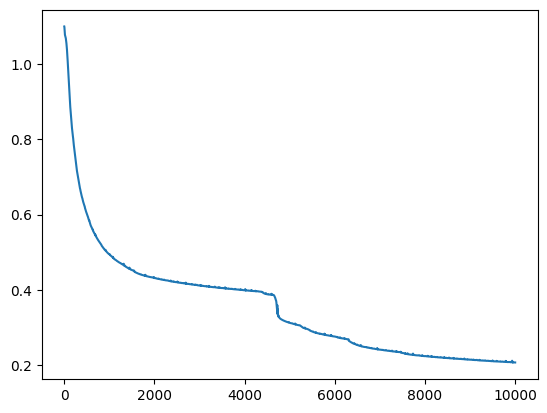

In [25]:
plt.plot(losses, label='Loss')

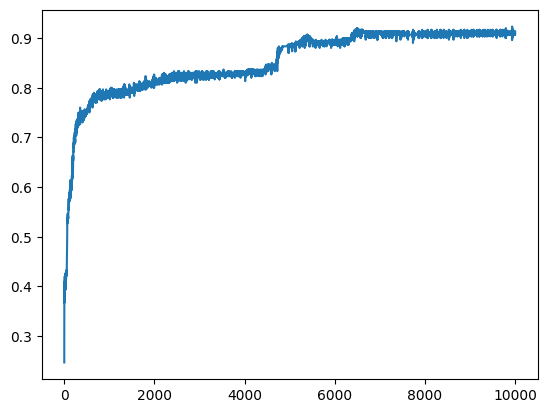

In [26]:
plt.plot(accuracies, label='Accuracy')

In [27]:
# RMS 0.74
# Momentum 0.93
# Adam 0.86

In [28]:
X_test, y_test = spiral_data(samples=100, classes=3)


dense1.forward(X_test)
activation1.forward(dense1.output)  
dense2.forward(activation1.output)

loss = activation2.forward(dense2.output, y_test)

predictions = np.argmax(activation2.output, axis=1)

if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)

accuracy = np.mean(predictions == y_test)

print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')

Test loss: 0.6266, Test accuracy: 0.7967


In [29]:
X, y = spiral_data(samples=1000, classes=3)

# dense1 = DenseLayer(2, 64)
dense1= DenseLayer(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)

activation1 = ActivationReLU()

dense2 = DenseLayer(64, 3)   

activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate=1e-2, decay=1e-5)

losses = []
accuracies= []

for i in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)  
    dense2.forward(activation1.output)

    data_loss = activation2.forward(dense2.output, y)

    regularization_loss = (activation2.loss.regularization_loss(dense1) +
                           activation2.loss.regularization_loss(dense2))
    
    
    loss = data_loss + regularization_loss

    losses.append(loss)

    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    accuracies.append(accuracy)
    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, lr: {optimizer.current_learning_rate:.4f} data_loss: {data_loss:.4f}, reg_loss: {regularization_loss:.4f}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

X_test, y_test = spiral_data(samples=100, classes=3)
dense1.forward(X_test)      
activation1.forward(dense1.output)
dense2.forward(activation1.output)      
loss = activation2.forward(dense2.output, y_test)
predictions = np.argmax(activation2.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


iteration 1, loss: 1.0987, accuracy: 0.2737, lr: 0.0100 data_loss: 1.0987, reg_loss: 0.0000
iteration 101, loss: 0.9847, accuracy: 0.5110, lr: 0.0100 data_loss: 0.9708, reg_loss: 0.0139
iteration 201, loss: 0.8290, accuracy: 0.6923, lr: 0.0100 data_loss: 0.7757, reg_loss: 0.0533
iteration 301, loss: 0.7511, accuracy: 0.7343, lr: 0.0100 data_loss: 0.6746, reg_loss: 0.0765
iteration 401, loss: 0.6950, accuracy: 0.7710, lr: 0.0100 data_loss: 0.6034, reg_loss: 0.0916
iteration 501, loss: 0.6555, accuracy: 0.7977, lr: 0.0100 data_loss: 0.5559, reg_loss: 0.0996
iteration 601, loss: 0.6222, accuracy: 0.8163, lr: 0.0099 data_loss: 0.5167, reg_loss: 0.1054
iteration 701, loss: 0.5987, accuracy: 0.8263, lr: 0.0099 data_loss: 0.4916, reg_loss: 0.1071
iteration 801, loss: 0.5796, accuracy: 0.8323, lr: 0.0099 data_loss: 0.4728, reg_loss: 0.1068
iteration 901, loss: 0.5649, accuracy: 0.8360, lr: 0.0099 data_loss: 0.4590, reg_loss: 0.1059
iteration 1001, loss: 0.5486, accuracy: 0.8393, lr: 0.0099 dat

Drop Layer

In [30]:
class DropLayer:
    def __init__(self, drop_rate):
        self.drop_rate = 1- drop_rate # we need a success rate if it is 0.2 then we need to keep 80% of the neurons

    def forward(self, inputs):
        self.inputs = inputs
        self.mask = np.random.binomial(1, self.drop_rate, size=inputs.shape) / self.drop_rate  # create a mask with the same shape as inputs, where each element is 1 with probability drop_rate and 0 otherwise
        self.output = self.inputs *  self.mask

    def backward(self, dvalues):
        self.dinputs = dvalues * self.mask
        

In [31]:
X, y = spiral_data(samples=1000, classes=3)

# dense1 = DenseLayer(2, 64)
dense1= DenseLayer(2, 64, weight_regularizer_l2=5e-4, bias_regularizer_l2=5e-4)

activation1 = ActivationReLU()

drop1 = DropLayer(0.2)  # 20% dropout

dense2 = DenseLayer(64, 3)   

activation2 = Activation_Softmax_Loss_CategoricalCrossentropy()

optimizer = Optimizer_Adam(learning_rate=1e-2, decay=1e-5)

losses = []
accuracies= []

for i in range(10001):

    dense1.forward(X)
    activation1.forward(dense1.output)
    drop1.forward(activation1.output)
    dense2.forward(drop1.output)

    data_loss = activation2.forward(dense2.output, y)

    regularization_loss = (activation2.loss.regularization_loss(dense1) +
                           activation2.loss.regularization_loss(dense2))
    
    
    loss = data_loss + regularization_loss

    losses.append(loss)

    predictions = np.argmax(activation2.output, axis=1)
    if len(y.shape) == 2:
        y = np.argmax(y, axis=1)
    accuracy = np.mean(predictions == y)
    accuracies.append(accuracy)
    if i % 100 == 0:
        print(f'iteration {i+1}, loss: {loss:.4f}, accuracy: {accuracy:.4f}, lr: {optimizer.current_learning_rate:.4f} data_loss: {data_loss:.4f}, reg_loss: {regularization_loss:.4f}', )


    activation2.backward(activation2.output, y)
    dense2.backward(activation2.dinputs)
    activation1.backward(dense2.dinputs)
    dense1.backward(activation1.dinputs)

    optimizer.pre_update_params()
    optimizer.update_params(dense1)
    optimizer.update_params(dense2)
    optimizer.post_update_params()

X_test, y_test = spiral_data(samples=100, classes=3)
dense1.forward(X_test)      
activation1.forward(dense1.output)
dense2.forward(activation1.output)      
loss = activation2.forward(dense2.output, y_test)
predictions = np.argmax(activation2.output, axis=1)
if len(y_test.shape) == 2:
    y_test = np.argmax(y_test, axis=1)
accuracy = np.mean(predictions == y_test)
print(f'Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}')


iteration 1, loss: 1.0986, accuracy: 0.3287, lr: 0.0100 data_loss: 1.0986, reg_loss: 0.0000
iteration 101, loss: 1.0573, accuracy: 0.4257, lr: 0.0100 data_loss: 1.0511, reg_loss: 0.0062
iteration 201, loss: 1.0422, accuracy: 0.4487, lr: 0.0100 data_loss: 1.0230, reg_loss: 0.0192
iteration 301, loss: 1.0490, accuracy: 0.4473, lr: 0.0100 data_loss: 1.0223, reg_loss: 0.0267
iteration 401, loss: 1.0453, accuracy: 0.4510, lr: 0.0100 data_loss: 1.0124, reg_loss: 0.0329
iteration 501, loss: 1.0487, accuracy: 0.4477, lr: 0.0100 data_loss: 1.0108, reg_loss: 0.0379
iteration 601, loss: 1.0454, accuracy: 0.4513, lr: 0.0099 data_loss: 1.0042, reg_loss: 0.0412
iteration 701, loss: 1.0480, accuracy: 0.4510, lr: 0.0099 data_loss: 1.0058, reg_loss: 0.0422
iteration 801, loss: 1.0552, accuracy: 0.4397, lr: 0.0099 data_loss: 1.0125, reg_loss: 0.0427
iteration 901, loss: 1.0485, accuracy: 0.4543, lr: 0.0099 data_loss: 1.0055, reg_loss: 0.0430
iteration 1001, loss: 1.0463, accuracy: 0.4560, lr: 0.0099 dat